# Import packages

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


import numpy as np
#from odeintw import odeintw
import pandas as pd
from scipy import interpolate

# from scipy.interpolate import PchipInterpolator
# import numpy as np
# import pandas as pd
# # 

import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.integrate import quad, ode, solve_ivp, odeint
from scipy.optimize import root
from scipy.optimize import fsolve

# from scipy.special import zeta, kn
import scipy.special as sp
from scipy.interpolate import interp1d, RectBivariateSpline
from math import sqrt, log, exp, log10, pi, atan
from mpmath import expint
from mpmath import findroot
from scipy.special import lambertw

plt.rc('text', usetex=True)
plt.rcParams['text.latex.preamble']=r"\usepackage{amsmath, amssymb}"
plt.rc('font', **{'family' : 'serif', 'size' : 15})


# Definitions

In [10]:
#-------------------------------------#
#    g*(T) and g*S(T) interpolation   #
#-------------------------------------#

gTab = pd.read_table(r"/home/yongxu/Documents/research/Research_Code/py_projects/BH_superradiance/Superradiance_code/Data/gstar.dat", names=['T','gstarS'])
Ttab = gTab.iloc[:,0] # temperature
gtab = gTab.iloc[:,1] # value
tck  = interpolate.splrep(Ttab, gtab, s=0)

def gstarT(T): 
    return interpolate.splev(T, tck, der=0)

gSTab = pd.read_table(r"/home/yongxu/Documents/research/Research_Code/py_projects/BH_superradiance/Superradiance_code/Data/gstarS.dat", names=['T','gstarS'])

TStab = gSTab.iloc[:,0]
gstab = gSTab.iloc[:,1]
tckS  = interpolate.splrep(TStab, gstab, s=0)

def gstarST(T): 
    return interpolate.splev(T, tckS, der = 0)


# gTab = pd.read_table(
#     "/home/yongxu/Documents/research/Research_Code/py_projects/BH_superradiance/Superradiance_code/Data/gstar.dat",
#     names=['T','gstar']
# )

# Ttab = gTab['T'].values
# gtab = gTab['gstar'].values

# gstarT = PchipInterpolator(Ttab, gtab, extrapolate=False)

# gSTab = pd.read_table(
#     "/home/yongxu/Documents/research/Research_Code/py_projects/BH_superradiance/Superradiance_code/Data/gstarS.dat",
#     names=['T','gstarS']
# )

# TStab = gSTab['T'].values
# gstab = gSTab['gstarS'].values

# gstarST = PchipInterpolator(TStab, gstab, extrapolate=False)


# -----------------------------
# Physical constants (GeV units)
# -----------------------------
G_F = 1.1663787e-5        # Fermi constant, GeV^-2
Mpl = 1.2209e19           # Planck mass, GeV
Mp = Mpl / np.sqrt(8*np.pi)
pi = np.pi
zeta3 = 1.2020569031595942


# -----------------------------
# Utility functions (with fix for T_from_rho_rad)
# -----------------------------
def rho_rad_from_T(T):
    """Radiation energy density from temperature using interpolated g*(T).
       T in GeV, returns rho in GeV^4.
    """
    T_arr = np.asarray(T)
    g = gstarT(T_arr)
    return (pi**2 / 30.0) * g * T_arr**4

def T_from_rho_rad(rho, tol=1e-10, maxiter=60):
    """
    Solve for T from rho using iterative scheme with gstarT(T).
    rho: scalar or array (GeV^4)
    Returns T in GeV (same shape)
    """
    rho_arr = np.asarray(rho)
    # protect extremely small/negative rho
    rho_safe = np.maximum(rho_arr, 1e-300)

    # initial guess: assume constant gstar_const
    gstar_const = 10.75
    T0 = (rho_safe * 30.0 / (pi**2) / gstar_const)**0.25

    T = T0
    # iterative fixed-point: T_new = (rho*30/pi^2 / gstarT(T_old))^(1/4)
    for _ in range(maxiter):
        g = gstarT(T)
        # protect g
        g = np.maximum(g, 1e-8)
        T_new = (rho_safe * 30.0 / (pi**2) / g)**0.25
        # relative change
        rel = np.max(np.abs((T_new - T) / np.maximum(T, 1e-20)))
        T = T_new
        if rel < tol:
            break
    else:
        # if not converged, still return last iterate but warn (commented out)
        # print("Warning: T_from_rho_rad did not converge fully; rel = {:.3e}".format(rel))
        pass

    # if input scalar return scalar
    if np.isscalar(rho):
        return float(T)
    return T

def H_from_rho(rho):
    return np.sqrt(8 * pi / 3.0 * rho / Mpl**2)

def f_eq(x):
    """Stable Fermi-Dirac distribution for array x = p/T."""
    x = np.array(x)
    out = np.zeros_like(x, dtype=float)
    mask = x < 700.0
    out[mask] = 1.0 / (np.exp(x[mask]) + 1.0)
    return out

# dof gs =2
def n_eq_T(T):
    """Equilibrium number density prefactor (per neutrino degree of freedom)."""
    return 2* 3.0/4.0 * zeta3 / (pi**2) * T**3


# -----------------------------
# Gamma_alpha(p,T)
# ----------------------------
# from arXiv:1909.13328
def Gamma_alpha_of_pT(p, T, flavor='e'):
    C_factors = {'e': 1.13, 'mu': 0.79, 'tau': 0.79}
    C = C_factors.get(flavor, 0.0)
    p_safe = np.maximum(p, 1e-300)
    T_safe = np.maximum(T, 1e-300)
    res = C * (G_F**2) * p_safe * T_safe**4
    return res 

# -----------------------------
# Thermal potential V_th(p,T)
# -----------------------------
def B_of_T(T, flavor):
    """
    Piecewise B(T) (in eV) based on https://arxiv.org/abs/astro-ph/0101524
    """
    T_MeV = T * 1e3
    if T_MeV <= 20.0:
        if flavor == 'e':
            return 10.79
        elif flavor == 'mu':
            return 3.02
        elif flavor == 'tau':
            return 3.02
    elif T_MeV <= 180.0:
        if flavor == 'e':
            return 10.79
        elif flavor == 'mu':
            return 10.79
        elif flavor == 'tau':
            return 3.02
    else:
        return 10.79

def V_thermal_of_pT(p, T, flavor='e'):
    p_safe = np.maximum(p, 1e-300)
    B_eV = B_of_T(T, flavor)
    B_GeV = B_eV * 1e-9
    return - B_GeV * (T**4) * p_safe

# -----------------------------
# Finite-density (asymmetry) potential V_D
# -----------------------------
def V_density_of_T(T, L_alpha=0.0, eta=0.0, flavor='e'):
    sign = 1.0 if flavor=='e' else -1.0
    pref = (2.0 * np.sqrt(2.0) * zeta3 / (pi**2)) * G_F * T**3
    return pref * (L_alpha + sign * eta / 4.0)

def V_effective_of_pT(p, T, L_alpha=0.0, eta=0.0, flavor='e'):
    return V_density_of_T(T, L_alpha=L_alpha, eta=eta, flavor=flavor) + V_thermal_of_pT(p, T, flavor=flavor)

# -----------------------------
# Oscillation production C_osc_for_flavor
# -----------------------------
def C_osc_for_flavor(fa, fs, ms, T, x_vals, sin2_2theta, flavor='e', L_alpha=0.0, eta=0.0):
    p = x_vals * T
    p_safe = np.maximum(p, 1e-300)
    Delta = ms**2 / (2.0 * p_safe)         # [GeV]
    Gamma_alpha = Gamma_alpha_of_pT(p_safe, T, flavor=flavor)  # [GeV]
    D = Gamma_alpha / 2.0
    Veff = V_effective_of_pT(p_safe, T, L_alpha=L_alpha, eta=eta, flavor=flavor)
    cos2theta = np.sqrt(np.maximum(1.0 - sin2_2theta, 0.0))
    denom = (Delta**2) * sin2_2theta + D**2 + (Delta * cos2theta - Veff)**2
    numer = (Gamma_alpha / 4.0) * (Delta**2) * sin2_2theta
    denom_safe = np.maximum(denom, 1e-300)
    # return (numer / denom_safe) * (fa - fs)
    return (numer / denom_safe) * (fa*(1-fs) - fs*(1-fa))

# -----------------------------
# Inflaton decay
# -----------------------------

def C_from_phi_decay(p, rho_phi, Gamma_phi, mphi, BR):
    """
    Approximates delta function as a narrow Gaussian in momentum q.
    q_grid: comoving momentum array
    a: scale factor
    rho_phi: inflaton energy density at this a
    Gamma_phi: total inflaton decay rate
    mphi: inflaton mass
    BR: branching ratio to sterile neutrino
    Returns df_s/dln a array.
    """
    n_phi = rho_phi / mphi
    p0 = mphi / 2.0

    sigma = p0 * 0.05  # 5% width to approximate delta function; good enough
    prefactor = BR * 8 * np.pi**2 * Gamma_phi * n_phi / mphi**2
    Cs_decay = prefactor * (1.0 / (np.sqrt(2*np.pi) * sigma)) * np.exp(-0.5 * ((p - p0)/sigma)**2)
    return Cs_decay

# -----------------------------
# comoving momentum grid q = a*p
# -----------------------------
## Small Trh and mass
q_min = 1e-2
q_max = 1e4
N_q = 140   
q_grid = np.logspace(np.log10(q_min), np.log10(q_max), N_q)

### Large Trh and mass
# q_min = 1e-2
# q_max = 1e14
# N_q = 200  
# q_grid = np.logspace(np.log10(q_min), np.log10(q_max), N_q)


# -----------------------------
# RHS building with four flavors
# -----------------------------
def make_rhs_lna_comoving_full(TR, ms, sin2_2theta, mphi, BR,
                               L_alpha_e=0.0, L_alpha_mu=0.0, L_alpha_tau=0.0,
                               eta=0.0, print_dlna=0.2,
                               flavor_for_Gamma='e'):
    TR_GeV = TR
    Gamma_phi = 2.45 * H_from_rho(rho_rad_from_T(TR_GeV))
    sin2_2th = sin2_2theta
    last_print = [-1e9]

    def rhs(ln_a, y):
        idx = 0
        rho_phi = y[idx]; idx += 1
        rho_rad = y[idx]; idx += 1

        f_e = y[idx: idx+N_q].copy(); idx += N_q
        f_s = y[idx: idx+N_q].copy(); idx += N_q
        rho_tot = np.maximum(rho_phi + rho_rad, 1e-300)
        H = H_from_rho(rho_tot)

        # ---- HERE use iterative T_from_rho_rad  ----
        T = T_from_rho_rad(np.maximum(rho_rad, 1e-300))
        a = np.exp(ln_a)

        # physical momentum p, and x = p/T
        p_grid = q_grid / a
        x_vals = p_grid / T

        f_eq_grid = f_eq(x_vals)

        coll_e = (Gamma_alpha_of_pT(p_grid, T, 'e') ) * (f_eq_grid - f_e)
        C_e = C_osc_for_flavor(f_e, f_s, ms, T, x_vals, sin2_2th, flavor='e', L_alpha=L_alpha_e, eta=eta)
        C_phi = C_from_phi_decay(p_grid, rho_phi, Gamma_phi, mphi, BR)

        prod_s = (C_e) / H +  C_phi/ H

        # prod_s =   C_phi/ H


        drho_phi_dlna = -3.0 * rho_phi - (Gamma_phi / H) * rho_phi
        drho_rad_dlna = -4.0 * rho_rad + (Gamma_phi / H) * rho_phi

        df_e_dlna = (coll_e - C_e) / H
        df_s_dlna = prod_s 

        if print_dlna and (ln_a - last_print[0]) >= print_dlna:
            ratio = rho_phi / np.maximum(rho_rad, 1e-300)
            # print(f"[ln a = {ln_a:.3f}] T = {T*1e3:.6f} MeV, rho_phi/rho_rad = {ratio:.3e}")
            print(f"[ln a = {ln_a:.3f}] T = {T*1e3:.6f} MeV")
            last_print[0] = ln_a
            
        out = np.empty_like(y)
        j = 0
        out[j] = drho_phi_dlna; j += 1
        out[j] = drho_rad_dlna; j += 1
        out[j:j+N_q] = df_e_dlna; j += N_q
        out[j:j+N_q] = df_s_dlna
        return out

    return rhs

# -----------------------------
# Runner
# -----------------------------
def run_ln_comoving_full(TR_MeV=4.0, Hubble_end = 1e-20, ms_keV=1.0, sin2_2theta=1e-2, mphi=1e2, BR=0.0,
                         ln_a_span=(0.0, 15.0),
                         L_alpha_e=0.0, L_alpha_mu=0.0, L_alpha_tau=0.0,
                         eta=0.0, print_dlna=0.5):
    TR = TR_MeV * 1e-3
    ms = ms_keV * 1e-6

    # initial conditions (tunable)
    rho_rad_init = 1e-20
    HI = Hubble_end 
    rho_phi_init = 3.0 * HI**2 * Mp**2
    f0 = np.zeros(N_q)
    y0 = np.concatenate([[rho_phi_init, rho_rad_init], f0, f0])

    rhs = make_rhs_lna_comoving_full(TR, ms, sin2_2theta, mphi, BR,
                                     L_alpha_e=L_alpha_e, L_alpha_mu=L_alpha_mu, L_alpha_tau=L_alpha_tau,
                                     eta=eta, print_dlna=print_dlna)

    # sol = solve_ivp(rhs, ln_a_span, y0, method='Radau', atol=1e-10, rtol=1e-10, max_step=0.01)
    sol = solve_ivp(rhs, ln_a_span, y0, method='BDF',    atol=1e-10, rtol=1e-10,  max_step=0.01)


    ln_a = sol.t
    a_array = np.exp(ln_a)
    n_t = len(ln_a)

    idx = 2
    f_e = sol.y[idx: idx+N_q, :]; idx += N_q
    f_s = sol.y[idx: idx+N_q, :]; idx += N_q
    
    # dof gs=2
    prefactor = 2.0 / (2.0 * np.pi**2) 
    n_e = np.empty(n_t)
    n_s = np.empty(n_t)
    n_eq = np.empty(n_t)
    # T_array =  T_from_rho_rad(sol.y[1])
    T_sol = T_from_rho_rad(sol.y[1])
    for i in range(n_t):
        a = a_array[i]
        T = T_sol[i]      
        x_grid = q_grid / (a * T)
        n_e[i] = prefactor * np.trapezoid(f_e[:, i] * q_grid**2, q_grid) / a**3
        n_s[i] = prefactor * np.trapezoid(f_s[:, i] * q_grid**2, q_grid) / a**3
        n_eq[i]  = prefactor * np.trapezoid(f_eq(x_grid) * q_grid**2, q_grid) / a**3

    neq = n_eq_T(T_sol)

    s_entropy = (2.0 * np.pi**2 / 45.0) * gstarST(T_sol) * (T_sol**3)

    Y_s = n_s / s_entropy

    return {
        'ln_a': ln_a,
        'a': a_array,
        'T': T_sol,
        'n_e': n_e,
        'n_s': n_s,
        'n_e_over_neq': n_e / neq,
        'n_s_over_neq': n_s / neq,
        'f_e': f_e,
        'f_s': f_s,
        'q_grid': q_grid,
        'sol': sol,
        'Y_s': Y_s, 
        'ms_keV': ms_keV
    }

# -----------------------------
# Plot 
# -----------------------------

def plot_n_over_n_eq(result, Tmax_MeV=None, filename=None):
    T = result['T']
    re = result['n_e_over_neq']
    # rmu = result['n_mu_over_neq']
    # rtau = result['n_tau_over_neq']
    rs = result['n_s_over_neq']

    if Tmax_MeV is not None:
        mask = (T * 1e3) <= Tmax_MeV
        Tp = T[mask] * 1e3
        rep = re[mask]; rsp = rs[mask]
        # rmup = rmu[mask]; rtp = rtau[mask]; 
    else:
        Tp = T * 1e3
        rep = re;  rsp = rs 
        # rmup = rmu; rtp = rtau;

    plt.figure(figsize=(7,5))
    plt.plot(Tp, rep, label=r"$\nu_e$", linewidth=2,  color='b')
    # plt.plot(Tp, rmup, label=r"$\nu_\mu$", linewidth=2, color='g')
    # plt.plot(Tp, rtp, label=r"$\nu_\tau$", linewidth=2, color='k', linestyle='--')
    plt.plot(Tp, rsp, label=r"$\nu_s$", linewidth=2, color='r')
  
    # plt.axhline(y=1, color='k', linestyle='--', linewidth=4)
    # plt.xscale("log")
    # plt.yscale("log")
    # plt.gca().invert_xaxis()  # Tem from high to low
    plt.xlabel(r'$T~[\text{MeV}]$')
    plt.ylabel(r'$n / n_{\rm eq}$')
    # plt.grid(alpha=0.4, which="both")
    plt.legend()
    plt.tight_layout()
        
    plt.savefig(filename, bbox_inches="tight")
    plt.show()    
    print(f"Saved file: {filename}")


def plot_energy_densities(result, filename=None):
    a = result['a']
    rho_phi = np.maximum(result['sol'].y[0], 1e-300)
    rho_rad = np.maximum(result['sol'].y[1], 1e-300)

    plt.figure(figsize=(7,5))
    plt.plot(a, rho_phi, label=r'$\rho_\phi$', color='b', linewidth=3)
    plt.plot(a, rho_rad, label=r'$\rho_R$', color='r', linewidth=3)
    plt.xscale("log")
    plt.yscale("log")
    plt.ylim(1e-18, 1e10)

    plt.xlabel(r'$a$')
    plt.ylabel(r'$\rho~[\text{GeV}^4] $')
    # plt.grid(alpha=0.4)
    plt.legend()
    plt.tight_layout()
    
    plt.savefig(filename, bbox_inches="tight")

    plt.show()
    print(f"Saved file: {filename}")

def T_at_rho_phi_eq_rho_R_interp(result):
    rho_phi = np.maximum(result['sol'].y[0], 1e-200)
    rho_rad = np.maximum(result['sol'].y[1], 1e-200)
    ln_a = result['ln_a']
    T_sol = result['T']

    # log ratio (much better behaved)
    logR = np.log(rho_phi / rho_rad)

    
    # find sign change of log ratio
    idx = np.where(np.diff(np.sign(logR)))[0]
    if len(idx) == 0:
        print("No reheating crossing found!")
        return None, None

    i = idx[0]

    # linear interpolation in ln a
    ln_a1, ln_a2 = ln_a[i], ln_a[i+1]
    y1, y2 = logR[i], logR[i+1]

    ln_a_eq = ln_a1 - y1 * (ln_a2 - ln_a1) / (y2 - y1)

    # interpolate temperature consistently in ln a
    T_eq = T_sol[i] + (T_sol[i+1] - T_sol[i]) * (ln_a_eq - ln_a1) / (ln_a2 - ln_a1)
    a_eq = np.exp(ln_a_eq)

    print(
        f"rho_phi = rho_rad at\n"
        f"  a = {a_eq:.6e}\n"
        f"  T = {T_eq*1e3:.6f} MeV"
    )

    return T_eq, a_eq


# def T_at_rho_phi_eq_rho_R_interp(result, filename=None):
#     rho_phi = result['sol'].y[0]
#     rho_rad = result['sol'].y[1]
#     ln_a = result['ln_a']
#     T_sol = result['T']

#     diff = rho_phi - rho_rad
#     sign_change_idx = np.where(np.diff(np.sign(diff)))[0]

#     if len(sign_change_idx) == 0:
#         print("No crossing found!")
#         return None, None

#     i = sign_change_idx[0]

#     ln_a_eq = ln_a[i] + (ln_a[i+1] - ln_a[i]) * (-diff[i]) / (diff[i+1] - diff[i])
#     T_eq = T_sol[i] + (T_sol[i+1] - T_sol[i]) * (ln_a_eq - ln_a[i]) / (ln_a[i+1] - ln_a[i])
#     a_eq = np.exp(ln_a_eq)

#     print(f"rho_phi = rho_rad at a = {a_eq:.3e}, Temperature T = {T_eq*1e3:.3f} MeV")
#     return T_eq, a_eq
   
    # plt.savefig(filename, bbox_inches="tight")
    # plt.show()
    # print(f"Saved file: {filename}")


def plot_temperature_evolution(result, filename=None):
    ln_a = result['ln_a']
    a = np.exp(ln_a)
    T = np.maximum(result['T'], 1e-10)

    plt.figure(figsize=(7,5))
    plt.plot(a, T*1e3, label=r'$T~[\text{MeV}]$', color='r', linewidth=3)

    Teq, aeq = T_at_rho_phi_eq_rho_R_interp(result)
    if Teq is not None and aeq is not None:
        # plt.axhline(y=Teq*1e3, color='r', linestyle='--', label=f"T_rh = {Teq*1e3:.2f} MeV")
        # plt.axvline(x=aeq, color='g', linestyle='--', label=f"a_rh = {aeq:.2e}")
        plt.axhline(y=Teq*1e3, color='gray', linestyle='--')
        plt.axvline(x=aeq, color='gray', linestyle='--')
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel(r'$a$')
    plt.ylabel(r'$T~[\text{MeV}]$')
    # plt.grid(alpha=0.4, which="both")
    plt.legend()
    plt.tight_layout()
 
    plt.savefig(filename, bbox_inches="tight")
    plt.show()

    print(f"Saved file: {filename}")

def plot_momentum_spectra_x(result, flavors=('e', 's'), filename=None):
    fmap = {'e': result['f_e'],  's': result['f_s']}
    ln_a_final = result['ln_a'][-1]
    a_final = np.exp(ln_a_final)
    # T_final = np.maximum(result['T'][-1], 1e-10)
    T_final = result['T'][-1]
    x = q_grid / (a_final * T_final)

    plt.figure(figsize=(7,5))
    plt.plot(x, x**3 * f_eq(x), color= 'gray', label=r'$\nu^{\text{eq}}_{\alpha}$')

    plt.plot(x, (x**3) * fmap['e'][:, -1], color= 'b', label=r'$\nu_e$')
    # plt.plot(x, (x**3) * fmap['mu'][:, -1], color= 'g', label=r'$\nu_\mu$')
    # plt.plot(x, (x**3) * fmap['tau'][:, -1], color= 'k', linestyle='--',  label=r'$\nu_\tau$')
    plt.plot(x, (x**3) * fmap['s'][:, -1], color= 'r',  label=r'$\nu_s$')

    plt.xscale("log")
    plt.yscale("log")
    # plt.xlim(1e-3, 1e2)

    plt.ylim(1e-20, 1e1)

    plt.xlabel(r'$x = p/T$')
    plt.ylabel(r'$x^3 f(x)$')
    # plt.grid(alpha=0.4, which="both")
    plt.legend()
    plt.tight_layout()
    plt.title(f"T = {T_final*1e3:.2f} MeV")
    plt.savefig(filename, bbox_inches="tight")

    plt.show()
    print(f"Saved file: {filename}")

#####################################################################
def find_spectrum_indices(result):
    T = result['T']
    a = result['a']
    ln_a = result['ln_a']

    # --- reheating point ---
    Teq, aeq = T_at_rho_phi_eq_rho_R_interp(result)
    if Teq is None:
        raise RuntimeError("No reheating point found")

    idx_rh = np.argmin(np.abs(a - aeq))

    # --- early time: one e-fold before reheating ---
    ln_a_early = ln_a[idx_rh] - 3.0
    idx_early = np.argmin(np.abs(ln_a - ln_a_early))

    # --- final time ---
    idx_final = -1

    return idx_early, idx_rh, idx_final


def plot_momentum_spectra_x_3T(result, filename=None):
    fmap = {
        'e': result['f_e'],
        's': result['f_s']
    }

    q_grid = result['q_grid']
    a = result['a']
    T = result['T']

    idx_early, idx_rh, idx_final = find_spectrum_indices(result)
    indices = [idx_early, idx_rh, idx_final]

    titles = [
        r"$T > T_{\rm rh}$",
        r"$T = T_{\rm rh}$",
        r"$T = T_{\rm final}$"
    ]

    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    for ax, idx, title in zip(axes, indices, titles):
        a_i = a[idx]
        T_i = T[idx]
        x = q_grid / (a_i * T_i)

        ax.plot(x, x**3 * f_eq(x), color='k', label=r'$\nu^{\text{eq}}_e$', linewidth=4)
        ax.plot(x, x**3 * fmap['e'][:, idx], color='b', label=r'$\nu_e$', linewidth=4)
        ax.plot(x, x**3 * fmap['s'][:, idx], color='r', label=r'$\nu_s$', linewidth=4)

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_ylim(1e-18, 1e1)
        ax.set_xlim(1e-3, 1e2)

        ax.set_xlabel(r'$x = p/T$')
        # ax.set_title(title + f"\n$T = {T_i*1e3:.3f}$MeV")
        ax.set_title(f"$T = {T_i*1e3:.2f}$MeV")


    axes[0].set_ylabel(r'$x^3 f(x)$')
    axes[0].legend()

    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")

    plt.show()

    if filename is not None:
        print(f"Saved file: {filename}")

# import numpy as np
# import matplotlib.pyplot as plt

def plot_momentum_spectra_fixed_T(result, T_targets=[0.9, 0.5, 0.13], include_final=True, filename=None):
    """
    Plot momentum spectra at fixed temperatures (in GeV).

    Parameters:
        result: dict containing 'f_e', 'f_s', 'q_grid', 'a', 'T'
        T_targets: list of temperatures in GeV to plot
        include_final: if True, also plot the last entry in result['T']
    """
    fmap = {'e': result['f_e'], 's': result['f_s']}
    q_grid = result['q_grid']
    a = result['a']
    T_array = result['T']  # in GeV

    # Find indices closest to target temperatures
    indices = [np.argmin(np.abs(T_array - Tt)) for Tt in T_targets]
    if include_final:
        indices.append(len(T_array) - 1)

    # Create titles for each subplot
    titles = [f"$T \\approx {T_array[idx]*1e3:.2f}$ MeV" for idx in indices]

    fig, axes = plt.subplots(1, len(indices), figsize=(5*len(indices), 5))
    if len(indices) == 1:
        axes = [axes]  # make iterable if only one subplot

    for ax, idx, title in zip(axes, indices, titles):
        a_i = a[idx]
        T_i = T_array[idx]
        x = q_grid / (a_i * T_i)

        ax.plot(x, x**3 * f_eq(x), 'm', label=r'$\nu^{\rm eq}_e$', linewidth=5)
        ax.plot(x, x**3 * fmap['e'][:, idx], 'b--', label=r'$\nu_e$', linewidth=5)
        ax.plot(x, x**3 * fmap['s'][:, idx], 'r', label=r'$\nu_s$', linewidth=5)

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlim(1e-3, 1e2)
        ax.set_ylim(1e-18, 1e1)
        ax.set_xlabel(r'$x = p/T$',size=20)
        ax.set_title(title)
        ax.tick_params(axis='both', which='major', labelsize=25)
        # ax.tick_params(axis='both', which='minor', labelsize=12)

    axes[0].set_ylabel(r'$x^3 f(x)$', size=20)
    axes[0].legend()
    plt.subplots_adjust(wspace=0.001)  # reduce space between subplots
    plt.tight_layout()

    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")
        print(f"Saved file: {filename}")

    plt.show()


############################################################
def plot_Ys(result, filename=None):
    a = result['a']
    Y_s = result.get('Y_s')
    if Y_s is None: 
        print("No Y_s in result; please use updated run_ln_comoving_full(...)")
        return
    ms = result.get("ms_keV", None)
    if ms is None:
        raise ValueError("result has no key 'ms_keV'")

    Y_s_plot = np.maximum(Y_s, 1e-20)

    plt.figure(figsize=(7,5))
    plt.plot(a, Y_s_plot,  color='b', label=r'$Y_s = n_s/s$',  linewidth=2)

    plt.axhline(y=4.3*1e-10/(ms*1e-6), 
                color='gray', linestyle='--', label=r'$\Omega_s h^2 =0.12$', linewidth=5)

    plt.xscale("log")
    plt.yscale("log")
    plt.ylim(1e-20, 1e0)

    plt.xlabel(r'$a$')
    plt.ylabel(r'$Y_s$')
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename, bbox_inches="tight")
    plt.show()

    print(f"Saved file: {filename}")


# DOFs

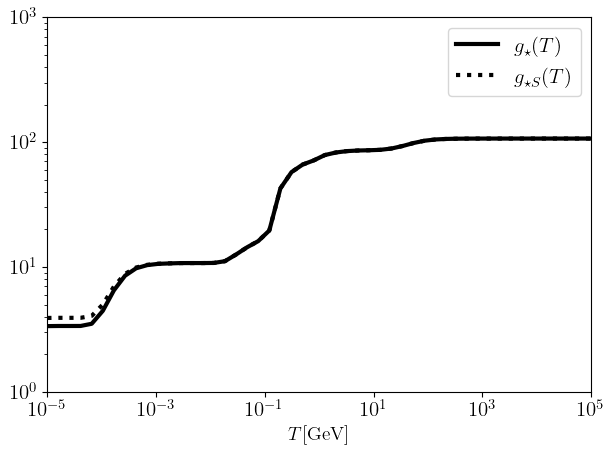

In [3]:
######################################################
######################################################
#####################################################
T_values = np.logspace(-5, 5)
gstar_values =gstarT(T_values)
gstarS_values = gstarST(T_values)

plt.loglog(T_values, gstar_values, 'k-', markersize=8,  linewidth=3, label=r'$g_{\star}(T)$')  # 'ro-' means red circles connected

plt.loglog(T_values, gstarS_values, 'k:', markersize=8,  linewidth=3, label=r'$g_{\star S}(T)$')  # 'ro-' means red circles connected

plt.xlabel(r'$T [\text{GeV}]$', fontsize=14)
# plt.ylabel(r'$\sin^2(2\theta)$', fontsize=14)

plt.legend()
plt.xlim(1e-5,1e5)
plt.ylim(1e0,1e3)
plt.legend(loc=0, prop={'size': 15} )

plt.savefig("./gs.pdf", bbox_inches="tight")
plt.tight_layout()
plt.show()


# Load Data X-ray

In [3]:
Xray =pd.read_csv(r"/home/yongxu/Documents/research/Research_Code/py_projects/Sterile_Neutrino_Reheating/Xray.csv", 
                  names=['ms','sin2'])
ms_Xray=   Xray.iloc[:,0] # ms
sin2_Xray = Xray.iloc[:,1] # mixing


eROSITA =pd.read_csv(r"/home/yongxu/Documents/research/Research_Code/py_projects/Sterile_Neutrino_Reheating/eROSITA.csv", 
                  names=['ms','sin2'])
ms_eROSITA=   eROSITA.iloc[:,0] # ms
sin2_eROSITA = eROSITA.iloc[:,1] # mixing


eXTP =pd.read_csv(r"/home/yongxu/Documents/research/Research_Code/py_projects/Sterile_Neutrino_Reheating/eXTP.csv", 
                  names=['ms','sin2'])
ms_eXTP=   eXTP.iloc[:,0] # ms
sin2_eXTP= eXTP.iloc[:,1] # mixing


# Phase Space Evolution

In [4]:
if __name__ == "__main__":
    res_test_ms7keV= run_ln_comoving_full(TR_MeV=500.0, Hubble_end=1e-15, ms_keV=7, 
                               sin2_2theta=1e-12, ln_a_span=(0,16), print_dlna=1.0, mphi=1, BR=3*1e-5)

[ln a = 0.000] T = 0.009751 MeV
[ln a = 1.001] T = 2446.789125 MeV
[ln a = 2.002] T = 1724.341120 MeV
[ln a = 3.002] T = 1194.320063 MeV
[ln a = 4.003] T = 824.421390 MeV
[ln a = 5.005] T = 528.986503 MeV
[ln a = 6.006] T = 267.117408 MeV
[ln a = 7.008] T = 125.888091 MeV
[ln a = 8.010] T = 50.199805 MeV
[ln a = 9.011] T = 19.674654 MeV
[ln a = 10.012] T = 7.316425 MeV
[ln a = 11.013] T = 2.689748 MeV
[ln a = 12.022] T = 0.984727 MeV
[ln a = 13.031] T = 0.369257 MeV
[ln a = 14.041] T = 0.150836 MeV
[ln a = 15.051] T = 0.062885 MeV


Saved file: f_ms7keV.pdf


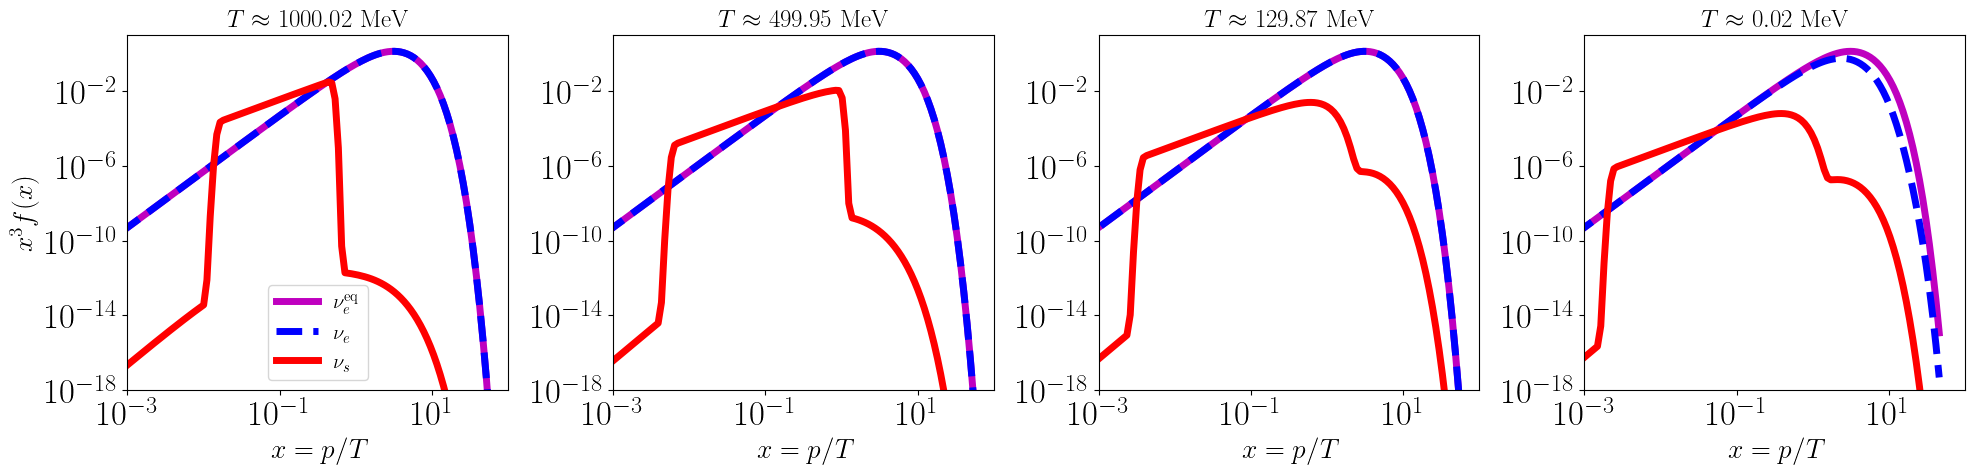

In [97]:
plot_momentum_spectra_fixed_T(res_test_ms7keV, T_targets=[1, 0.5, 0.13], include_final=True, filename="f_ms7keV.pdf")

In [118]:
# plot_momentum_spectra_x_3T(res_test_ms7keV, filename="f_ms7keV.pdf")

In [6]:
if __name__ == "__main__":
    res_test_ms7keV_BR0= run_ln_comoving_full(TR_MeV=500.0, Hubble_end=1e-15, ms_keV=7, 
                               sin2_2theta=1e-12, ln_a_span=(0,16), print_dlna=1.0, mphi=1, BR=0)

[ln a = 0.000] T = 0.009751 MeV
[ln a = 1.009] T = 2440.471072 MeV
[ln a = 2.009] T = 1719.722216 MeV
[ln a = 3.019] T = 1186.826743 MeV
[ln a = 4.025] T = 817.023709 MeV
[ln a = 5.031] T = 521.876894 MeV
[ln a = 6.035] T = 260.561904 MeV
[ln a = 7.036] T = 123.012950 MeV
[ln a = 8.037] T = 48.936574 MeV
[ln a = 9.039] T = 19.163855 MeV
[ln a = 10.040] T = 7.115818 MeV
[ln a = 11.043] T = 2.611153 MeV
[ln a = 12.048] T = 0.960447 MeV
[ln a = 13.051] T = 0.362338 MeV
[ln a = 14.061] T = 0.148328 MeV
[ln a = 15.071] T = 0.061684 MeV


Saved file: f_ms7keV_BR0.pdf


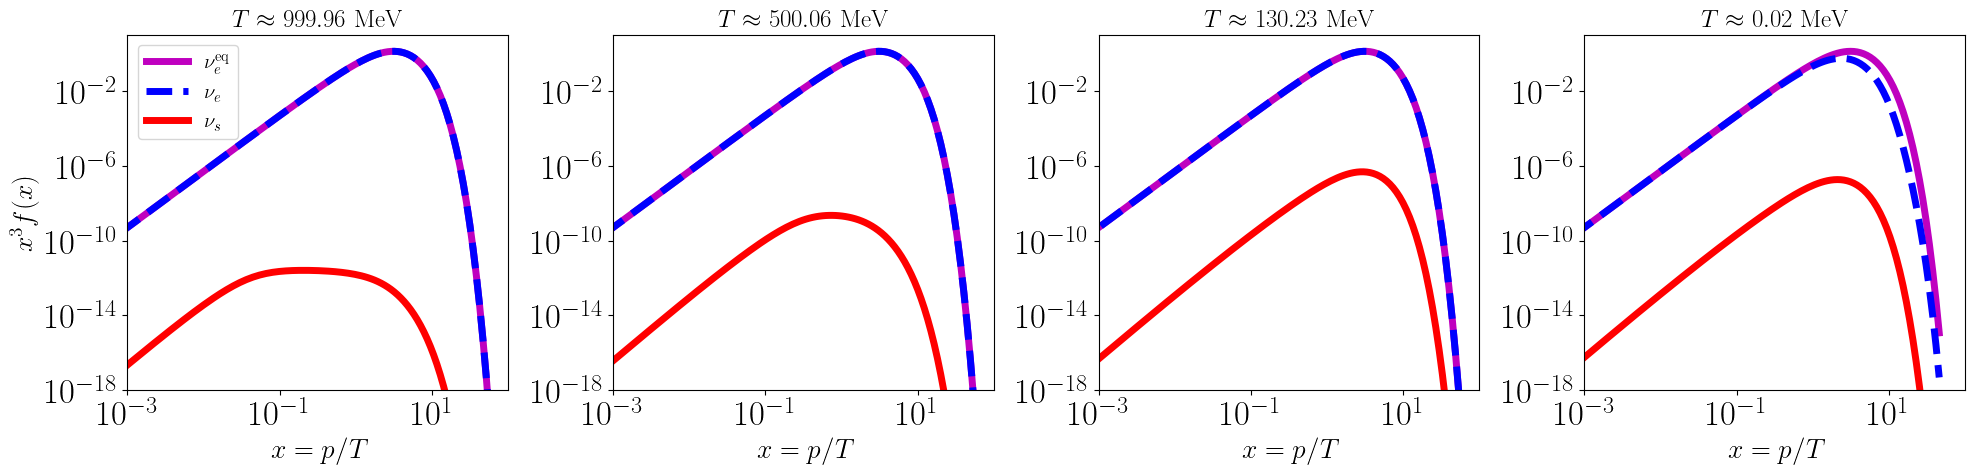

In [98]:
plot_momentum_spectra_fixed_T(res_test_ms7keV_BR0, T_targets=[1, 0.5, 0.130], include_final=True, filename="f_ms7keV_BR0.pdf")

In [119]:
# plot_momentum_spectra_x_3T(res_test_ms7keV_BR0, filename="f_ms7keV_BR0.pdf")

In [8]:
if __name__ == "__main__":
    res_test_ms7keV_mixing0= run_ln_comoving_full(TR_MeV=500.0, Hubble_end=1e-15, ms_keV=7, 
                               sin2_2theta=1e-50, ln_a_span=(0,16), print_dlna=1.0, mphi=1, BR=3*1e-5)

[ln a = 0.000] T = 0.009751 MeV
[ln a = 1.001] T = 2446.789125 MeV
[ln a = 2.002] T = 1724.341094 MeV
[ln a = 3.002] T = 1194.320042 MeV
[ln a = 4.003] T = 824.426222 MeV
[ln a = 5.005] T = 528.991033 MeV
[ln a = 6.005] T = 267.256188 MeV
[ln a = 7.007] T = 126.008167 MeV
[ln a = 8.008] T = 50.293175 MeV
[ln a = 9.010] T = 19.688091 MeV
[ln a = 10.011] T = 7.330286 MeV
[ln a = 11.015] T = 2.684167 MeV
[ln a = 12.017] T = 0.990154 MeV
[ln a = 13.017] T = 0.374018 MeV
[ln a = 14.027] T = 0.152552 MeV
[ln a = 15.037] T = 0.063703 MeV


Saved file: f_ms7keV_mixing0.pdf


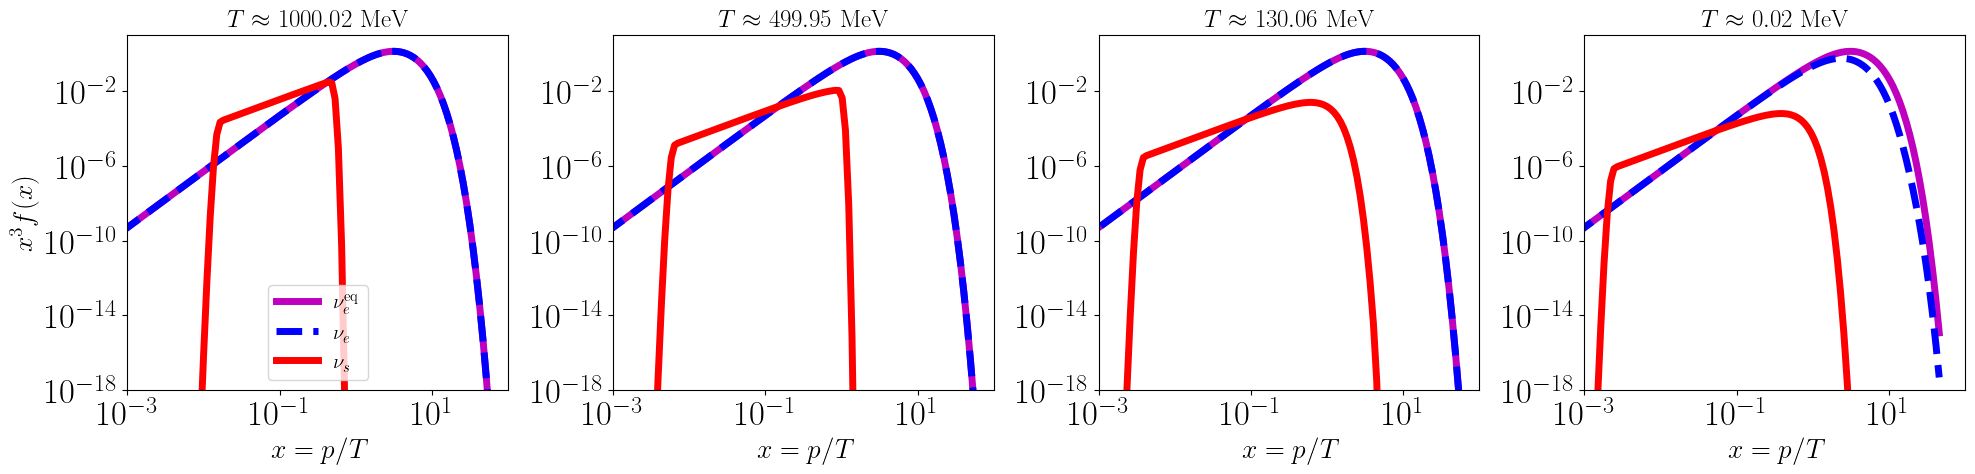

In [99]:
plot_momentum_spectra_fixed_T(res_test_ms7keV_mixing0, T_targets=[1, 0.5, 0.13], include_final=True, filename="f_ms7keV_mixing0.pdf")

rho_phi = rho_rad at
  a = 1.652447e+02
  T = 501.178854 MeV


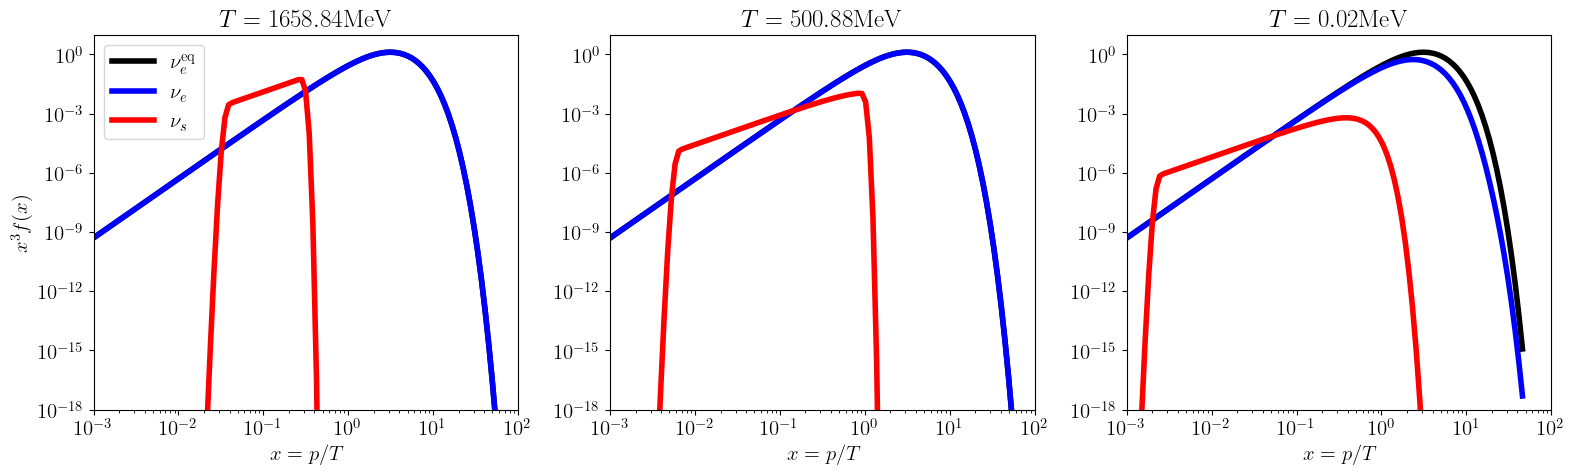

Saved file: f_ms7keV_mixing0.pdf


In [75]:
plot_momentum_spectra_x_3T(res_test_ms7keV_mixing0, filename="f_ms7keV_mixing0.pdf")

# Test Running 

In [4]:
#############################
# comoving momenta
#############################
q_min = 1e-2
q_max = 1e4
N_q = 140   
q_grid = np.logspace(np.log10(q_min), np.log10(q_max), N_q)

In [5]:
if __name__ == "__main__":
    res_test= run_ln_comoving_full(TR_MeV=500, Hubble_end=1e-15, ms_keV=180, 
                               sin2_2theta=5*1e-12, ln_a_span=(0,16), print_dlna=1.0, mphi=1, BR=1e-6)


# if __name__ == "__main__":
    # res_test= run_ln_comoving_full(TR_MeV=500, Hubble_end=1e-10, ms_keV=2.15, 
                               # sin2_2theta=1e-80, ln_a_span=(0,24), print_dlna=1.0, mphi=1, BR=1e-4)

[ln a = 0.000] T = 0.009751 MeV
[ln a = 1.000] T = 2447.463430 MeV
[ln a = 2.000] T = 1725.291039 MeV
[ln a = 3.002] T = 1194.302849 MeV
[ln a = 4.004] T = 824.051821 MeV
[ln a = 5.004] T = 529.272028 MeV
[ln a = 6.006] T = 267.241231 MeV
[ln a = 7.008] T = 125.964641 MeV
[ln a = 8.009] T = 50.233271 MeV
[ln a = 9.011] T = 19.685426 MeV
[ln a = 10.014] T = 7.307771 MeV
[ln a = 11.015] T = 2.684274 MeV
[ln a = 12.022] T = 0.984713 MeV
[ln a = 13.024] T = 0.371589 MeV
[ln a = 14.034] T = 0.151675 MeV
[ln a = 15.044] T = 0.063285 MeV


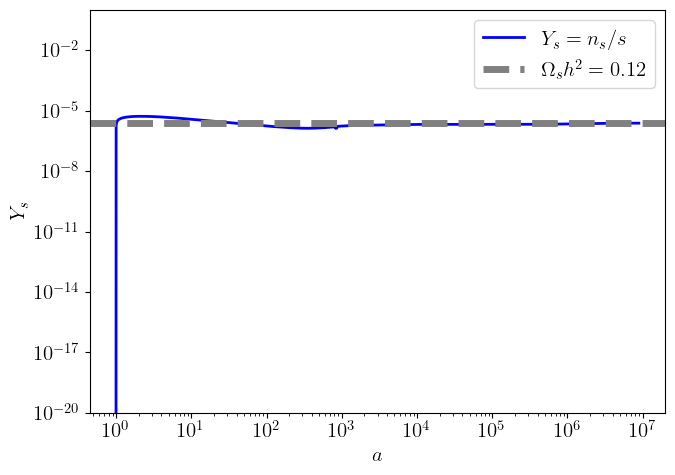

Saved file: Ys_test.pdf


In [6]:
plot_Ys(res_test, filename="Ys_test.pdf")

In [7]:
res_test["Y_s"][-1] *180*1e-6

np.float64(4.3364265461824674e-10)

rho_phi = rho_rad at
  a = 1.652443e+02
  T = 501.179489 MeV


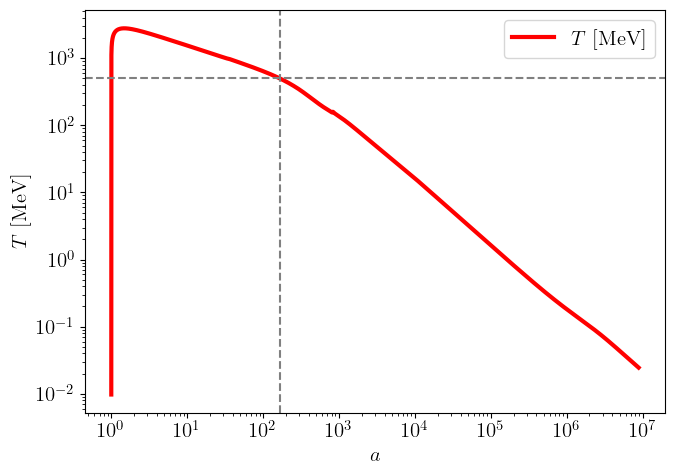

Saved file: T_test.pdf


In [8]:
plot_temperature_evolution(res_test, filename="T_test.pdf")

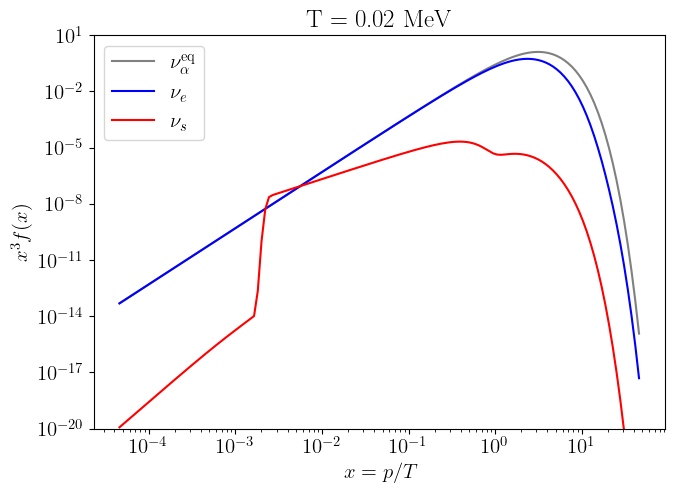

Saved file: f_test.pdf


In [11]:
plot_momentum_spectra_x(res_test, flavors=('e','s'), filename="f_test.pdf")

In [13]:
# plot_n_over_n_eq(res_test, Tmax_MeV=None,filename="n_test.pdf")

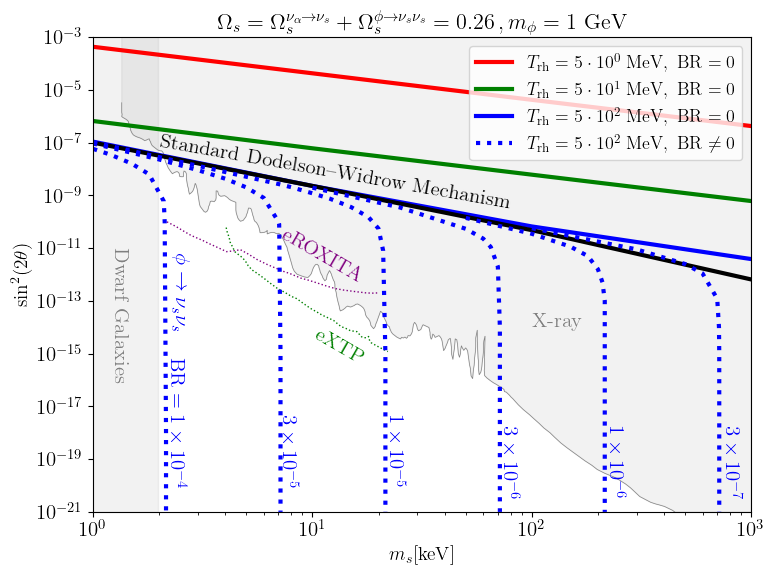

In [5]:
######################################################
###############DATA FROM TEST RUNING##################
######################################################
# BR =0 TR=5
ms_TR5 = np.array([ 1e0,     1e1,    1e2,  1e3])
s2_TR5 = np.array([ 4.3* 1e-4, 4.25* 1e-5,  4.2*1e-6, 4.25*1e-7])
######################################################

#TR=50
ms_TR50 = np.array([1e0, 1e1, 1e2, 1e3])
s2_TR50 = np.array( [6.6*1e-7, 6.1*1e-8, 6.1*1e-9, 6.1*1e-10])
######################################################

#TR=500 BR=0 
ms_TR500 = np.array([1e0,        1e1,       1e2,       1e3])
s2_TR500 = np.array( [1.09*1e-7, 2.28*1e-9, 6.65*1e-11,  3.85*1e-12])
######################################################

#TR=5000 BR=0
ms_TR5000 = np.array([1e0, 1e1, 1e2, 1e3])
s2_TR5000 = np.array( [1*1e-7, 2.28*1e-9, 4.8*1e-11,  6.5*1e-13])

######################################################
#TR=500; BR=3* 1e-7; mphi=1GeV 
ms_TR500_BR3ep7 = np.array([100,          300,     500,        600,      700,  713,  715, 715])
s2_TR500_BR3ep7 = np.array( [5.7*1e-11, 9*1e-12, 2.5*1e-12,   1.1*1e-12, 1.2*1e-13,  1e-14, 1e-15, 1e-21])
######################################################
#TR=500; BR=1e-6; mphi=1GeV
ms_TR500_BR1ep6 = np.array([50,           100,          150,   180,  200,  210,  215,    215 ])
s2_TR500_BR1ep6 = np.array( [1.4*1e-10,  3.5*1e-11,  1.14*1e-11, 5*1e-12, 1.6*1e-12, 5*1e-13, 1e-13, 1e-21])

######################################################
#TR=500; BR=3* 1e-6; mphi=1GeV 
ms_TR500_BR3ep6 = np.array([10,        25,          50,         60,       65,       70,        71.5,      71.5])
s2_TR500_BR3ep6 = np.array( [1.96*1e-9, 3.5*1e-10, 5.4*1e-11, 2.3*1e-11, 1.1*1e-11, 2*1e-12,  1e-14, 1e-21])

######################################################
#TR=500; BR=1e-5; mphi=1GeV
ms_TR500_BR1ep5 = np.array([1,  7, 8, 1e1,  12,  15, 18, 20, 21, 21.5, 21.5])
s2_TR500_BR1ep5 = np.array( [1.04*1e-7, 2.7*1e-9, 2.05*1e-9, 1.2*1e-9, 7.5*1e-10, 3.6*1e-10, 1.5*1e-10, 5.5*1e-11, 8*1e-12, 1e-15, 1e-21])
######################################################
#TR=500; BR=3* 1e-5; mphi=1GeV
ms_TR500_BR3ep5 = np.array([1, 2,          3,          4,       5,      6,          7,       7.05,   7.15, 7.15 ])
s2_TR500_BR3ep5 = np.array( [9.3 *1e-8, 2.3 *1e-8, 9.1*1e-9, 4.3*1e-9, 2*1e-9, 8*1e-10, 1e-10, 8*1e-11, 1e-15,1e-21])
######################################################
#TR=500; BR=1e-4; mphi=1GeV
ms_TR500_BR1ep4 = np.array([ 1,        1.2,      1.5,       1.8,       2.1,    2.12,       2.15, 2.15])
s2_TR500_BR1ep4 = np.array( [5.8*1e-8, 3.5*1e-8, 1.6*1e-8, 6.3*1e-9, 6.0*1e-10, 1.0*1e-10, 1*1e-18, 1*1e-21])
#####################################################

ms_values = np.logspace(-3, 3)
plt.figure(figsize=(8,6))
##############################################
plt.plot(ms_Xray, sin2_Xray,'gray', linewidth=0.5)
plt.plot(ms_eROSITA, sin2_eROSITA, "purple", linestyle= 'dotted',linewidth=1)
plt.plot(ms_eXTP, sin2_eXTP, "g:", linewidth=1)
######################################################
plt.loglog(ms_TR5, s2_TR5, 'r-', markersize=8,  linewidth=3,label=r'$T_\text{rh} =5\cdot 10^{0}~\text{MeV}, ~\text{BR}=0$')  # 'ro-' means red circles connected
plt.loglog(ms_TR50, s2_TR50, 'g-', markersize=8,  linewidth=3,label=r'$T_\text{rh} =5\cdot10^{1}~\text{MeV}, ~\text{BR}=0$')  # 'ro-' means red circles connected
plt.loglog(ms_TR500, s2_TR500, 'b-', markersize=8,  linewidth=3,label=r'$T_\text{rh} =5\cdot 10^{2}~\text{MeV}, ~\text{BR}=0$')  # 'ro-' means red circles connected
# plt.loglog(ms_TR5000, s2_TR5000, 'k-', markersize=8,  linewidth=3,label=r'$T_\text{rh} =5\cdot 10^{3}~\text{MeV}, ~\text{BR}=0$')  # 'ro-' means red circles connected
plt.loglog(ms_TR5000, s2_TR5000, 'k-', markersize=8,  linewidth=3)  # 'ro-' means red circles connected

plt.loglog(ms_TR500_BR3ep7, s2_TR500_BR3ep7, 'b:', markersize=8,  linewidth=3, label=r'$T_\text{rh} =5\cdot 10^{2}~\text{MeV}, ~\text{BR} \neq 0$')  # 'ro-' means red circles connected

# plt.loglog(ms_TR5000, s2_TR5000, 'k--', markersize=8,  linewidth=3,label=r'$\text{Standard Dodelson–Widrow Mechanism}$')  # 'ro-' means red circles connected

# Analytic prediction
# plt.loglog(ms_values, sin2_theta_fun(ms_values, TR), 'k:', linewidth=3, label="Ana")
# plt.loglog(ms_values, DW_Sin2_2theta(ms_values), 'b:', linewidth=3, label="Standard Dodelson Widrow")

#################################################################

plt.loglog(ms_TR500_BR1ep6, s2_TR500_BR1ep6, 'b:', markersize=8,  linewidth=3)  # 'ro-' means red circles connected
plt.loglog(ms_TR500_BR3ep6, s2_TR500_BR3ep6, 'b:', markersize=8,  linewidth=3)  # 'ro-' means red circles connected

plt.loglog(ms_TR500_BR1ep5, s2_TR500_BR1ep5, 'b:', markersize=8,  linewidth=3 )  # 'ro-' means red circles connected
plt.loglog(ms_TR500_BR3ep5, s2_TR500_BR3ep5, 'b:', markersize=8,  linewidth=3 )  # 'ro-' means red circles connected

plt.loglog(ms_TR500_BR1ep4, s2_TR500_BR1ep4, 'b:', markersize=8,  linewidth=3,)  # 'ro-' means red circles connected


######################################################
######################################################
# plt.axvline(x=43, ymin=1e-12,ymax=0.57, color='blue', linestyle=':', linewidth=3)
# plt.axvline(x=4.3, ymin=1e-12,ymax=0.6, color='blue', linestyle='--', linewidth=3)


fillxDG=np.logspace(-3, log10(1.98))
plt.fill_between(fillxDG, 1e-21, 1e0,color='gray',alpha=0.1)
######################################################
x1 = ms_Xray
y1_lower = sin2_Xray
y1_upper = np.ones_like(sin2_Xray) * max(sin2_Xray) * 1e10   # constant upper boundary

# Second filled region (rectangle from max(ms_Xray) to 1e3)
x2 = np.logspace(np.log10(max(ms_Xray)), 3)
y2_lower = np.ones_like(x2) * 1e-21
y2_upper = np.ones_like(x2) * 1e0

# Combine into one polygon (go around boundary)
xs = np.concatenate([x1, x2, x2[::-1], x1[::-1]])
ys = np.concatenate([y1_upper, y2_upper, y2_lower[::-1], y1_lower[::-1]])

plt.fill(xs, ys, alpha=0.1, color="gray")
######################################################
plt.text(1.2*1e0, 1e-16, r'$\text{Dwarf Galaxies}$', rotation=-90, color = "gray")
plt.text(1*1e2, 1e-14, r'$\text{X-ray}$', rotation=0, color = "gray")
plt.text(0.7*1e1, 0.5*1e-12, r'$\text{eROXITA}$', rotation=-30, color = "purple")
plt.text(1*1e1, 0.4*1e-15, r'$\text{eXTP}$', rotation=-30, color = "g")


plt.text(2, 3*1e-10, r'$\text{Standard Dodelson–Widrow Mechanism}$', rotation=-10, color = "black", size=15)

plt.text(2.3*1e0, 1e-14, r'$\phi \to \nu_s \nu_s$', rotation=-90, color = "blue")

plt.text(2.2*1e0, 1e-20, r'$\text{BR} =1\times 10^{-4}$', rotation=-90, color = "blue")

plt.text(7.2*1e0, 1e-20, r'$3\times 10^{-5}$', rotation=-90, color = "blue")
plt.text(22, 1e-20, r'$1\times 10^{-5}$', rotation=-90, color = "blue")
plt.text(73, 4*1e-21, r'$3\times 10^{-6}$', rotation=-90, color = "blue")
plt.text(221, 4*1e-21, r'$1\times 10^{-6}$', rotation=-90, color = "blue")
plt.text(752, 4*1e-21, r'$3\times 10^{-7}$', rotation=-90, color = "blue")

# plt.plot(7, 1e-12, marker='*', color='gold', markersize=20)

#################################################################

plt.xlabel(r'$m_s [\text{keV}]$', fontsize=14)
plt.ylabel(r'$\sin^2(2\theta)$', fontsize=14)
# plt.title(r'$Y_s m_s = 4.3\times10^{-10}~\text{GeV}; m_\phi =1~\text{GeV}$', fontsize=16)

plt.title(r'$\Omega_s= \Omega^{\nu_{\alpha} \to \nu_s}_s +\Omega^{\phi \to \nu_s \nu_s}_s =0.26\,,  m_\phi =1~\text{GeV}$', fontsize=16)
# plt.title(r'$\Omega_s= \Omega^{\nu_{\alpha} \to \nu_s}_s +\Omega^{\phi \to \nu_s \nu_s}_s \simeq 0.26$', fontsize=16)

plt.legend()
plt.xlim(1e0,1e3)
plt.ylim(1e-21,1e-3)
plt.legend(loc=1, prop={'size': 13} )

plt.savefig("./PS_New.pdf", bbox_inches="tight")
plt.tight_layout()
plt.show()


# Large Inflaton mass and reheating temperature

In [329]:
### Large Trh and mass
# q_min = 1e9
# q_max = 1e17
# N_q   = 150  
# q_grid = np.logspace(np.log10(q_min), np.log10(q_max), N_q)

# if __name__ == "__main__":
#     res_test= run_ln_comoving_full(TR_MeV=5*1e13, Hubble_end=3.5*1e8, ms_keV=50, 
#                                sin2_2theta=1.4*1e-10, ln_a_span=(0,45), print_dlna=1.0, mphi=1*1e13, BR=1e-4)

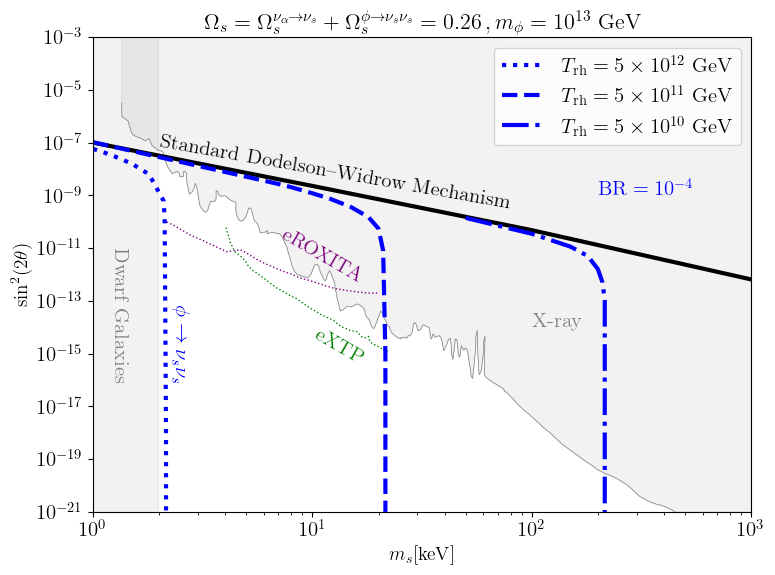

In [137]:
######################################################
###############DATA FROM TEST RUNING##################
######################################################

#TR=5e5 BR=0
ms_TR5e5  = np.array([1e0, 1e1, 1e2, 1e3])
s2_TR5e5  = np.array( [1*1e-7, 2.28*1e-9, 4.8*1e-11,  6.5*1e-13])

######################################################
#TR=5e15 MeV; BR=1e-4; mphi=1e13GeV
ms_TR5e15_BR1ep4 = np.array([ 1,        1.2,      1.5,       1.8,       2.1,    2.12,       2.15, 2.15])
s2_TR5e15_BR1ep4 = np.array( [5.8*1e-8, 3.5*1e-8, 1.6*1e-8, 6.3*1e-9, 6.0*1e-10, 1.0*1e-10, 1*1e-18, 1*1e-21])
#####################################################

######################################################
#TR=5e14 MeV; BR=1e-4; mphi=1e13GeV
ms_TR5e14_BR1ep4 = np.array([ 1,  7, 8, 1e1,  12,  15, 18, 20, 21, 21.5, 21.5])
s2_TR5e14_BR1ep4 = np.array( [1.04*1e-7, 2.7*1e-9, 2.05*1e-9, 1.2*1e-9, 7.5*1e-10, 3.6*1e-10, 1.5*1e-10, 5.5*1e-11, 8*1e-12, 1e-15, 1e-21])
#####################################################


######################################################
#TR=5e13 MeV; BR=1e-4; mphi=1e13GeV
ms_TR5e13_BR1ep4 = np.array([50,  100, 150, 180, 200,  210,  215,    215 ])
s2_TR5e13_BR1ep4 = np.array( [1.4*1e-10,  3.5*1e-11,  1.14*1e-11, 5*1e-12, 1.6*1e-12, 5*1e-13, 1e-13, 1e-21])
#################################

#####################################################
ms_values = np.logspace(-3, 3)
plt.figure(figsize=(8,6))
##############################################
plt.plot(ms_Xray, sin2_Xray,'gray', linewidth=0.5)
plt.plot(ms_eROSITA, sin2_eROSITA, "purple", linestyle= 'dotted',linewidth=1)
plt.plot(ms_eXTP, sin2_eXTP, "g:", linewidth=1)
#################################################################


plt.loglog(ms_TR5e5, s2_TR5e5, 'k-', markersize=8,  linewidth=3)  # 'ro-' means red circles connected

plt.loglog(ms_TR5e15_BR1ep4, s2_TR5e15_BR1ep4, 'b:', markersize=8,  linewidth=3, label=r'$T_{\text{rh}} = 5\times 10^{12}~\text{GeV}$')  # 'ro-' means red circles connected


plt.loglog(ms_TR5e14_BR1ep4, s2_TR5e14_BR1ep4, 'b--', markersize=8,  linewidth=3, label=r'$T_{\text{rh}} = 5\times 10^{11}~\text{GeV}$')  # 'ro-' means red circles connected

plt.loglog(ms_TR5e13_BR1ep4, s2_TR5e13_BR1ep4, 'b-.', markersize=8,  linewidth=3, label=r'$T_{\text{rh}} = 5\times 10^{10}~\text{GeV}$')  # 'ro-' means red circles connected

######################################################
######################################################
# plt.axvline(x=43, ymin=1e-12,ymax=0.57, color='blue', linestyle=':', linewidth=3)
# plt.axvline(x=4.3, ymin=1e-12,ymax=0.6, color='blue', linestyle='--', linewidth=3)


fillxDG=np.logspace(-3, log10(1.98))
plt.fill_between(fillxDG, 1e-21, 1e0,color='gray',alpha=0.1)
######################################################
x1 = ms_Xray
y1_lower = sin2_Xray
y1_upper = np.ones_like(sin2_Xray) * max(sin2_Xray) * 1e10   # constant upper boundary

# Second filled region (rectangle from max(ms_Xray) to 1e3)
x2 = np.logspace(np.log10(max(ms_Xray)), 3)
y2_lower = np.ones_like(x2) * 1e-21
y2_upper = np.ones_like(x2) * 1e0

# Combine into one polygon (go around boundary)
xs = np.concatenate([x1, x2, x2[::-1], x1[::-1]])
ys = np.concatenate([y1_upper, y2_upper, y2_lower[::-1], y1_lower[::-1]])

plt.fill(xs, ys, alpha=0.1, color="gray")
######################################################
plt.text(1.2*1e0, 1e-16, r'$\text{Dwarf Galaxies}$', rotation=-90, color = "gray")
plt.text(1*1e2, 1e-14, r'$\text{X-ray}$', rotation=0, color = "gray")
plt.text(0.7*1e1, 0.5*1e-12, r'$\text{eROXITA}$', rotation=-30, color = "purple")
plt.text(1*1e1, 0.4*1e-15, r'$\text{eXTP}$', rotation=-30, color = "g")


plt.text(2, 3*1e-10, r'$\text{Standard Dodelson–Widrow Mechanism}$', rotation=-10, color = "black", size=15)
plt.text(2.3*1e0, 1e-16, r'$\phi \to \nu_s \nu_s$', rotation=-90, color = "blue")

# plt.text(2.3*1e0, 1e-14, r'$\phi \to \nu_s \nu_s$', rotation=-90, color = "blue")

# plt.text(2.2*1e0, 0.5* 1e-20, r'$T_{\text{rh}} = 5\times 10^{12}~\text{GeV}$', rotation=-90, color = "blue")
# plt.text(22*1e0, 0.5* 1e-20, r'$T_{\text{rh}} = 5\times 10^{11}~\text{GeV}$', rotation=-90, color = "blue")
# plt.text(222*1e0, 0.5* 1e-20, r'$T_{\text{rh}} = 5\times 10^{10}~\text{GeV}$', rotation=-90, color = "blue")

# plt.text(7.2*1e0, 1e-20, r'$3\times 10^{-5}$', rotation=-90, color = "blue")
# plt.text(22, 1e-20, r'$1\times 10^{-5}$', rotation=-90, color = "blue")
# plt.text(73, 4*1e-21, r'$3\times 10^{-6}$', rotation=-90, color = "blue")
# plt.text(221, 4*1e-21, r'$1\times 10^{-6}$', rotation=-90, color = "blue")
# plt.text(752, 4*1e-21, r'$3\times 10^{-7}$', rotation=-90, color = "blue")

# plt.plot(7, 1e-12, marker='*', color='gold', markersize=20)
plt.text(2*1e2, 1e-9, r'$\text{BR}=10^{-4}$', rotation=0, color = "blue")

#################################################################

plt.xlabel(r'$m_s [\text{keV}]$', fontsize=14)
plt.ylabel(r'$\sin^2(2\theta)$', fontsize=14)
# plt.title(r'$Y_s m_s = 4.3\times10^{-10}~\text{GeV}; m_\phi =1~\text{GeV}$', fontsize=16)

plt.title(r'$\Omega_s= \Omega^{\nu_{\alpha} \to \nu_s}_s +\Omega^{\phi \to \nu_s \nu_s}_s =0.26\,,  m_\phi =10^{13}~\text{GeV}$', fontsize=16)
# plt.title(r'$\Omega_s= \Omega^{\nu_{\alpha} \to \nu_s}_s +\Omega^{\phi \to \nu_s \nu_s}_s \simeq 0.26$', fontsize=16)

plt.legend()
plt.xlim(1e0,1e3)
plt.ylim(1e-21,1e-3)
plt.legend(loc=0, prop={'size': 15} )

plt.savefig("./PS_Large_Trh.pdf", bbox_inches="tight")
plt.tight_layout()
plt.show()


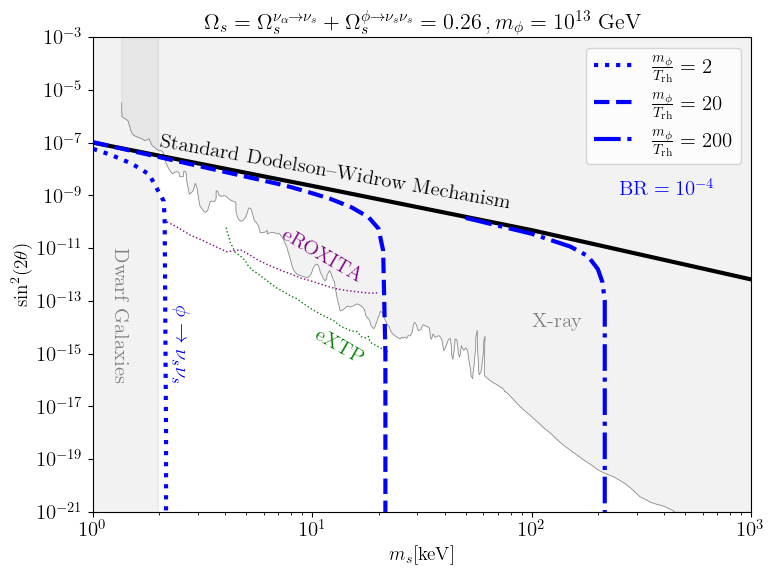

In [138]:
######################################################
###############DATA FROM TEST RUNING##################
######################################################

#TR=5e5 BR=0
ms_TR5e5  = np.array([1e0, 1e1, 1e2, 1e3])
s2_TR5e5  = np.array( [1*1e-7, 2.28*1e-9, 4.8*1e-11,  6.5*1e-13])

######################################################
#TR=5e15 MeV; BR=1e-4; mphi=1e3GeV
ms_TR5e15_BR1ep4 = np.array([ 1,        1.2,      1.5,       1.8,       2.1,    2.12,       2.15, 2.15])
s2_TR5e15_BR1ep4 = np.array( [5.8*1e-8, 3.5*1e-8, 1.6*1e-8, 6.3*1e-9, 6.0*1e-10, 1.0*1e-10, 1*1e-18, 1*1e-21])
#####################################################

######################################################
#TR=5e14 MeV; BR=1e-4; mphi=1e3GeV
ms_TR5e14_BR1ep4 = np.array([ 1,  7, 8, 1e1,  12,  15, 18, 20, 21, 21.5, 21.5])
s2_TR5e14_BR1ep4 = np.array( [1.04*1e-7, 2.7*1e-9, 2.05*1e-9, 1.2*1e-9, 7.5*1e-10, 3.6*1e-10, 1.5*1e-10, 5.5*1e-11, 8*1e-12, 1e-15, 1e-21])
#####################################################


######################################################
#TR=5e13 MeV; BR=1e-4; mphi=1e3GeV
ms_TR5e13_BR1ep4 = np.array([50,  100, 150, 180,  200,  210,  215,    215 ])
s2_TR5e13_BR1ep4 = np.array( [1.4*1e-10,  3.5*1e-11,  1.14*1e-11, 5*1e-12, 1.6*1e-12, 5*1e-13, 1e-13, 1e-21])
#################################

#####################################################
ms_values = np.logspace(-3, 3)
plt.figure(figsize=(8,6))
##############################################
plt.plot(ms_Xray, sin2_Xray,'gray', linewidth=0.5)
plt.plot(ms_eROSITA, sin2_eROSITA, "purple", linestyle= 'dotted',linewidth=1)
plt.plot(ms_eXTP, sin2_eXTP, "g:", linewidth=1)
#################################################################


plt.loglog(ms_TR5e5, s2_TR5e5, 'k-', markersize=8,  linewidth=3)  # 'ro-' means red circles connected

# plt.loglog(ms_TR5e15_BR1ep4, s2_TR5e15_BR1ep4, 'b:', markersize=8,  linewidth=3, label=r'$T_{\text{rh}} = \frac{m_\phi}{2}$')  # 'ro-' means red circles connected


# plt.loglog(ms_TR5e14_BR1ep4, s2_TR5e14_BR1ep4, 'b--', markersize=8,  linewidth=3, label=r'$T_{\text{rh}} = \frac{m_\phi}{20}$')  # 'ro-' means red circles connected

# plt.loglog(ms_TR5e13_BR1ep4, s2_TR5e13_BR1ep4, 'b-.', markersize=8,  linewidth=3, label=r'$T_{\text{rh}} = \frac{m_\phi}{200}$')  # 'ro-' means red circles connected

plt.loglog(ms_TR5e15_BR1ep4, s2_TR5e15_BR1ep4, 'b:', markersize=8,  linewidth=3, label=r'$\frac{m_\phi}{T_{\text{rh}}} =2$')  # 'ro-' means red circles connected


plt.loglog(ms_TR5e14_BR1ep4, s2_TR5e14_BR1ep4, 'b--', markersize=8,  linewidth=3, label=r'$\frac{m_\phi}{T_{\text{rh}}} =20$')  # 'ro-' means red circles connected

plt.loglog(ms_TR5e13_BR1ep4, s2_TR5e13_BR1ep4, 'b-.', markersize=8,  linewidth=3, label=r'$\frac{m_\phi}{T_{\text{rh}}} =200$')  # 'ro-' means red circles connected


######################################################
######################################################
# plt.axvline(x=43, ymin=1e-12,ymax=0.57, color='blue', linestyle=':', linewidth=3)
# plt.axvline(x=4.3, ymin=1e-12,ymax=0.6, color='blue', linestyle='--', linewidth=3)


fillxDG=np.logspace(-3, log10(1.98))
plt.fill_between(fillxDG, 1e-21, 1e0,color='gray',alpha=0.1)
######################################################
x1 = ms_Xray
y1_lower = sin2_Xray
y1_upper = np.ones_like(sin2_Xray) * max(sin2_Xray) * 1e10   # constant upper boundary

# Second filled region (rectangle from max(ms_Xray) to 1e3)
x2 = np.logspace(np.log10(max(ms_Xray)), 3)
y2_lower = np.ones_like(x2) * 1e-21
y2_upper = np.ones_like(x2) * 1e0

# Combine into one polygon (go around boundary)
xs = np.concatenate([x1, x2, x2[::-1], x1[::-1]])
ys = np.concatenate([y1_upper, y2_upper, y2_lower[::-1], y1_lower[::-1]])

plt.fill(xs, ys, alpha=0.1, color="gray")
######################################################
plt.text(1.2*1e0, 1e-16, r'$\text{Dwarf Galaxies}$', rotation=-90, color = "gray")
plt.text(1*1e2, 1e-14, r'$\text{X-ray}$', rotation=0, color = "gray")
plt.text(0.7*1e1, 0.5*1e-12, r'$\text{eROXITA}$', rotation=-30, color = "purple")
plt.text(1*1e1, 0.4*1e-15, r'$\text{eXTP}$', rotation=-30, color = "g")


plt.text(2, 3*1e-10, r'$\text{Standard Dodelson–Widrow Mechanism}$', rotation=-10, color = "black", size=15)

plt.text(2.3*1e0, 1e-16, r'$\phi \to \nu_s \nu_s$', rotation=-90, color = "blue")

# plt.text(2.2*1e0, 0.5* 1e-20, r'$T_{\text{rh}} = 5\times 10^{12}~\text{GeV}$', rotation=-90, color = "blue")
# plt.text(22*1e0, 0.5* 1e-20, r'$T_{\text{rh}} = 5\times 10^{11}~\text{GeV}$', rotation=-90, color = "blue")
# plt.text(222*1e0, 0.5* 1e-20, r'$T_{\text{rh}} = 5\times 10^{10}~\text{GeV}$', rotation=-90, color = "blue")

# plt.text(7.2*1e0, 1e-20, r'$3\times 10^{-5}$', rotation=-90, color = "blue")
# plt.text(22, 1e-20, r'$1\times 10^{-5}$', rotation=-90, color = "blue")
# plt.text(73, 4*1e-21, r'$3\times 10^{-6}$', rotation=-90, color = "blue")
# plt.text(221, 4*1e-21, r'$1\times 10^{-6}$', rotation=-90, color = "blue")
# plt.text(752, 4*1e-21, r'$3\times 10^{-7}$', rotation=-90, color = "blue")

# plt.plot(7, 1e-12, marker='*', color='gold', markersize=20)
plt.text(2.5*1e2, 1e-9, r'$\text{BR}=10^{-4}$', rotation=0, color = "blue")

#################################################################

plt.xlabel(r'$m_s [\text{keV}]$', fontsize=14)
plt.ylabel(r'$\sin^2(2\theta)$', fontsize=14)
# plt.title(r'$Y_s m_s = 4.3\times10^{-10}~\text{GeV}; m_\phi =1~\text{GeV}$', fontsize=16)

plt.title(r'$\Omega_s= \Omega^{\nu_{\alpha} \to \nu_s}_s +\Omega^{\phi \to \nu_s \nu_s}_s =0.26\,,  m_\phi =10^{13}~\text{GeV}$', fontsize=16)
# plt.title(r'$\Omega_s= \Omega^{\nu_{\alpha} \to \nu_s}_s +\Omega^{\phi \to \nu_s \nu_s}_s \simeq 0.26$', fontsize=16)

plt.legend()
plt.xlim(1e0,1e3)
plt.ylim(1e-21,1e-3)
plt.legend(loc=0, prop={'size': 15} )

plt.savefig("./PS_Large_Trh_mphi.pdf", bbox_inches="tight")
plt.tight_layout()
plt.show()


# Pure Inflaton Decay

In [34]:
def BR_fun(mphi_Trh_ratio, ms):
    res = 28.7/ms * 1e-5 * mphi_Trh_ratio # in keV
    return res

# This assumes that Gamma = 3/2 Hrh
def Ys_Inflaton(Trh, mphi, Br):
    res = 3/2 * Br * Trh/mphi 
    return res

# # Eq.(6.9) astro-ph/0101524v3
# def DW_Sin2_2theta(ms):
#     return (0.12/0.3) * (100/ms)**2 * 1e-10

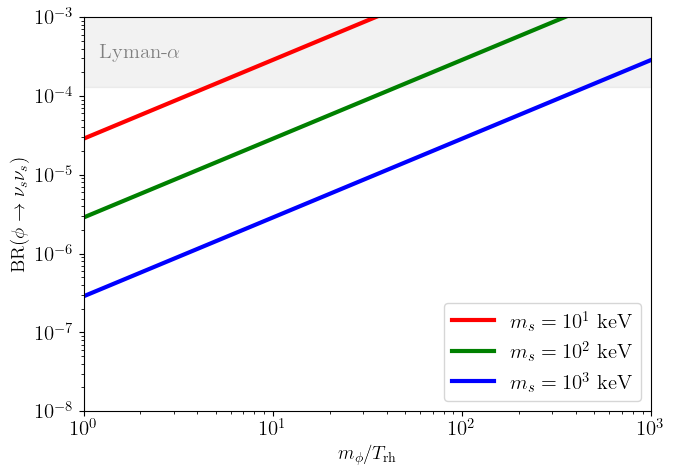

In [35]:
plt.figure(figsize=(7,5))

mphi_Trh = np.logspace(-3, 3)

BR1 = BR_fun(mphi_Trh, 10)
BR2 = BR_fun(mphi_Trh, 100)
BR3 = BR_fun(mphi_Trh, 1000)


plt.plot(mphi_Trh, BR1 , 'r-', markersize=8,  linewidth=3,label=r'$m_s  = 10^{1}~\text{keV}$')  # 'ro-' means red circles connected
plt.plot(mphi_Trh, BR2 , 'g-', markersize=8,  linewidth=3,label=r'$m_s  = 10^{2}~\text{keV}$')  # 'ro-' means red circles connected
plt.plot(mphi_Trh, BR3 , 'b-', markersize=8,  linewidth=3,label=r'$m_s  = 10^{3}~\text{keV}$')  # 'ro-' means red circles connected

plt.xlabel(r'$m_\phi/T_{\text{rh}}$', fontsize=14)
plt.ylabel(r'$\text{BR}(\phi \to \nu_s \nu_s)$', fontsize=14)
# plt.title(r'$Y_s m_s = 4.3\times10^{-10}~\text{GeV}; m_\phi =1~\text{GeV}$', fontsize=16)

plt.fill_between(mphi_Trh , 1.3*1e-4, 1e0,color='gray',alpha=0.1)
fillingx = np.logspace(-1, 0)
plt.fill_between(fillingx, 1e-10, 1e0,color='gray',alpha=0.1)

plt.text(1.2*1e0, 3*1e-4, r'$\text{Lyman-}\alpha$', rotation=0, color = "gray")

plt.xlim(1e0,1e3)
plt.ylim(1e-8,1e-3)
plt.xscale("log")
plt.yscale("log")
plt.legend(loc='lower right', prop={'size': 15} )

plt.savefig("./BR.pdf", bbox_inches="tight")
plt.tight_layout()
plt.show()
